In [1]:
# @title # Connect to Drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# @title #  Necessary libraries

!pip install torch_geometric
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import functional as F
from sklearn.metrics import classification_report


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.8 MB/s eta 0:00:00


In [3]:
# @title # Load the Dataset

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EEG.machinelearing_data_BRMH.csv")

print(data.info())
print("\n")
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Columns: 1149 entries, no. to COH.F.gamma.r.O1.s.O2
dtypes: float64(1144), int64(1), object(4)
memory usage: 8.3+ MB
None


   no. sex   age    eeg.date  education     IQ       main.disorder  \
0    1   M  57.0   2012.8.30        NaN    NaN  Addictive disorder   
1    2   M  37.0    2012.9.6        6.0  120.0  Addictive disorder   
2    3   M  32.0   2012.9.10       16.0  113.0  Addictive disorder   
3    4   M  35.0   2012.10.8       18.0  126.0  Addictive disorder   
4    5   M  36.0  2012.10.18       16.0  112.0  Addictive disorder   

      specific.disorder  AB.A.delta.a.FP1  AB.A.delta.b.FP2  ...  \
0  Alcohol use disorder         35.998557         21.717375  ...   
1  Alcohol use disorder         13.425118         11.002916  ...   
2  Alcohol use disorder         29.941780         27.544684  ...   
3  Alcohol use disorder         21.496226         21.846832  ...   
4  Alcohol use disorder         37.775667  

In [4]:
print(data.describe())


              no.         age   education          IQ  AB.A.delta.a.FP1  \
count  945.000000  945.000000  930.000000  932.000000        945.000000   
mean   473.000000   30.594804   13.438710  101.580472         20.182936   
std    272.942302   11.781592    2.550461   17.022414         11.282022   
min      1.000000   18.000000    0.000000   49.000000          3.272260   
25%    237.000000   21.730000   12.000000   91.000000         12.784872   
50%    473.000000   26.150000   13.000000  102.000000         17.065286   
75%    709.000000   35.450000   16.000000  114.000000         24.492760   
max    945.000000   71.880000   20.000000  145.000000         92.826192   

       AB.A.delta.b.FP2  AB.A.delta.c.F7  AB.A.delta.d.F3  AB.A.delta.e.Fz  \
count        945.000000       945.000000       945.000000       945.000000   
mean          21.177584        17.749553        18.901698        20.447079   
std           12.230662        10.003598         9.079482         9.742912   
min         

In [5]:
# @title # Cleaning Steps
missing_values = data.isna().sum()

print("Missing values per column:\n", missing_values[missing_values > 0])

total_missing = data.isna().sum().sum()
print("\nTotal number of missing values in the dataset:", total_missing)


Missing values per column:
 education        15
IQ               13
Unnamed: 122    945
dtype: int64

Total number of missing values in the dataset: 973


In [6]:
# @title # Cleaning Steps
data = data.drop(columns=['Unnamed: 122'])
data['education'].fillna(data['education'].median(), inplace=True)
data['IQ'].fillna(data['IQ'].median(), inplace=True)


<ipython-input-6-79031f18f4b4>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['education'].fillna(data['education'].median(), inplace=True)
<ipython-input-6-79031f18f4b4>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [7]:
# @title # Cleaning Steps
print(data.isna().sum())


no.                      0
sex                      0
age                      0
eeg.date                 0
education                0
                        ..
COH.F.gamma.p.P4.r.O1    0
COH.F.gamma.p.P4.s.O2    0
COH.F.gamma.q.T6.r.O1    0
COH.F.gamma.q.T6.s.O2    0
COH.F.gamma.r.O1.s.O2    0
Length: 1148, dtype: int64


In [8]:
duplicates = data.duplicated().sum()
print("Total number of duplicate rows:", duplicates)


Total number of duplicate rows: 0


In [9]:
# @title # Each Main Disorder's Total Count
disorder_counts = data["main.disorder"].value_counts()

print(disorder_counts)

main.disorder
Mood disorder                         266
Addictive disorder                    186
Trauma and stress related disorder    128
Schizophrenia                         117
Anxiety disorder                      107
Healthy control                        95
Obsessive compulsive disorder          46
Name: count, dtype: int64


<ipython-input-10-4cd5732c88bf>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data["main.disorder"], palette='Set2')


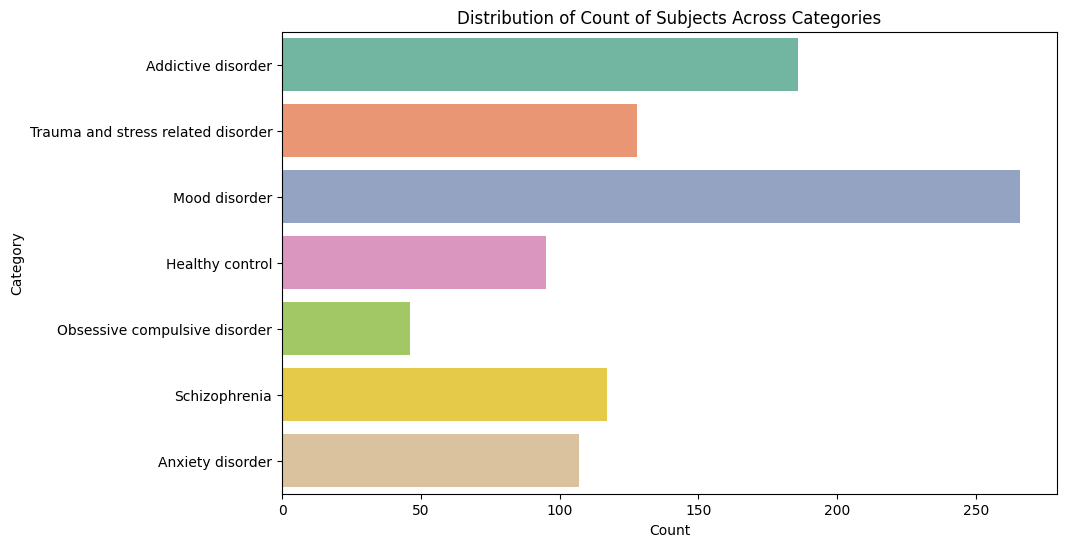

In [10]:
# @title # Visualizing
plt.figure(figsize=(10, 6))
sns.countplot(y=data["main.disorder"], palette='Set2')
plt.title('Distribution of Count of Subjects Across Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


In [11]:
# @title # Changing Categorical Values to Numeric Values Using Label Encoding
label_encoder = LabelEncoder()
data['main.disorder'] = label_encoder.fit_transform(data['main.disorder'])


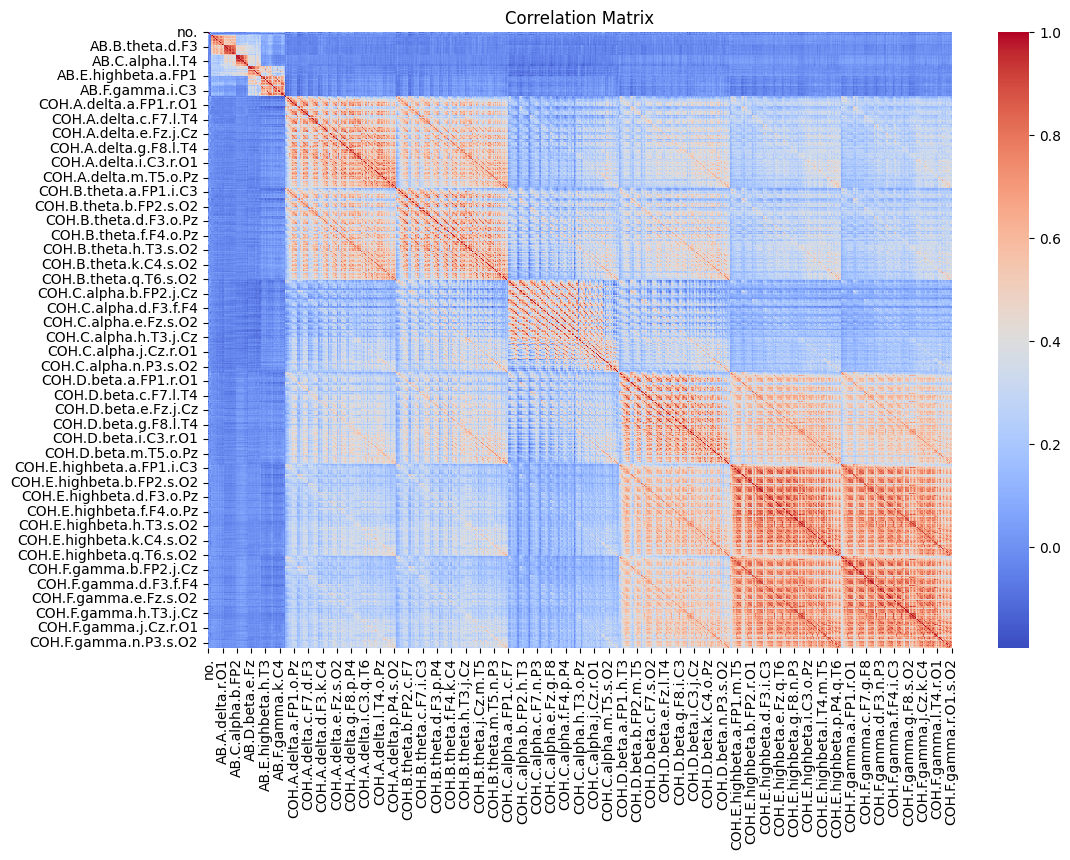

In [12]:
# @title # Reducing Feature Space part 1
numeric_data = data.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
corr_matrix = numeric_data.corr()  # Now we use only numeric columns
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [13]:
# @title # Reducing Feature Space part 2
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(f"Before dropping co-related columns, dataset size is: {len(data.columns)}")
data = data.drop(columns=to_drop)
print(f"Dropped columns: {to_drop}")
print(f"Size of total Dropped columns: {len(to_drop)}")
print(f"After dropping co-related columns, dataset size is: {len(data.columns)}")


Before dropping co-related columns, dataset size is: 1148
Dropped columns: ['AB.B.theta.b.FP2', 'AB.B.theta.e.Fz', 'AB.B.theta.f.F4', 'AB.B.theta.k.C4', 'AB.C.alpha.b.FP2', 'AB.C.alpha.c.F7', 'AB.C.alpha.d.F3', 'AB.C.alpha.e.Fz', 'AB.C.alpha.f.F4', 'AB.C.alpha.g.F8', 'AB.C.alpha.i.C3', 'AB.C.alpha.j.Cz', 'AB.C.alpha.k.C4', 'AB.C.alpha.p.P4', 'AB.D.beta.b.FP2', 'AB.D.beta.e.Fz', 'AB.D.beta.f.F4', 'AB.E.highbeta.f.F4', 'AB.E.highbeta.p.P4', 'AB.F.gamma.f.F4', 'AB.F.gamma.o.Pz', 'AB.F.gamma.p.P4', 'AB.F.gamma.r.O1', 'COH.A.delta.e.Fz.r.O1', 'COH.A.delta.f.F4.m.T5', 'COH.A.delta.f.F4.q.T6', 'COH.A.delta.f.F4.r.O1', 'COH.A.delta.f.F4.s.O2', 'COH.B.theta.b.FP2.r.O1', 'COH.B.theta.b.FP2.s.O2', 'COH.B.theta.e.Fz.m.T5', 'COH.B.theta.e.Fz.q.T6', 'COH.B.theta.e.Fz.r.O1', 'COH.B.theta.e.Fz.s.O2', 'COH.B.theta.f.F4.m.T5', 'COH.B.theta.f.F4.p.P4', 'COH.B.theta.f.F4.q.T6', 'COH.B.theta.f.F4.r.O1', 'COH.B.theta.f.F4.s.O2', 'COH.B.theta.g.F8.r.O1', 'COH.B.theta.j.Cz.r.O1', 'COH.B.theta.j.Cz.s.O2', 'COH

In [14]:
# @title # Node and Edge features
Nodes = [col for col in data.columns if 'AB' in col]
Edges = [col for col in data.columns if 'COH' in col]

print("Nodes Columns:", Nodes)
print("Edge Columns:", Edges)

Nodes Columns: ['AB.A.delta.a.FP1', 'AB.A.delta.b.FP2', 'AB.A.delta.c.F7', 'AB.A.delta.d.F3', 'AB.A.delta.e.Fz', 'AB.A.delta.f.F4', 'AB.A.delta.g.F8', 'AB.A.delta.h.T3', 'AB.A.delta.i.C3', 'AB.A.delta.j.Cz', 'AB.A.delta.k.C4', 'AB.A.delta.l.T4', 'AB.A.delta.m.T5', 'AB.A.delta.n.P3', 'AB.A.delta.o.Pz', 'AB.A.delta.p.P4', 'AB.A.delta.q.T6', 'AB.A.delta.r.O1', 'AB.A.delta.s.O2', 'AB.B.theta.a.FP1', 'AB.B.theta.c.F7', 'AB.B.theta.d.F3', 'AB.B.theta.g.F8', 'AB.B.theta.h.T3', 'AB.B.theta.i.C3', 'AB.B.theta.j.Cz', 'AB.B.theta.l.T4', 'AB.B.theta.m.T5', 'AB.B.theta.n.P3', 'AB.B.theta.o.Pz', 'AB.B.theta.p.P4', 'AB.B.theta.q.T6', 'AB.B.theta.r.O1', 'AB.B.theta.s.O2', 'AB.C.alpha.a.FP1', 'AB.C.alpha.h.T3', 'AB.C.alpha.l.T4', 'AB.C.alpha.m.T5', 'AB.C.alpha.n.P3', 'AB.C.alpha.o.Pz', 'AB.C.alpha.q.T6', 'AB.C.alpha.r.O1', 'AB.C.alpha.s.O2', 'AB.D.beta.a.FP1', 'AB.D.beta.c.F7', 'AB.D.beta.d.F3', 'AB.D.beta.g.F8', 'AB.D.beta.h.T3', 'AB.D.beta.i.C3', 'AB.D.beta.j.Cz', 'AB.D.beta.k.C4', 'AB.D.beta.l.T4', 

In [15]:
# @title # Standardize the features
scaler = StandardScaler()
data[Nodes] = scaler.fit_transform(data[Nodes])


In [16]:
X = data[Nodes].values
print("Node Features Shape:", X.shape)


Node Features Shape: (945, 91)


In [17]:

coherence_matrix = data[Edges].values
print("Edge shape:",coherence_matrix.shape)

Edge shape: (945, 840)


In [18]:
# @title # Creating Edge For the Graph
num_nodes = X.shape[1]
edge_list = []

for i in range(num_nodes):
    for j in range(num_nodes):
        edge_list.append([i, j])

edge_array = np.array(edge_list).T
edge_index = torch.tensor(edge_array, dtype=torch.long)

edge_attr = torch.tensor(coherence_matrix.flatten(), dtype=torch.float)



In [19]:
# @title # Creating Graph Object
x = torch.tensor(X, dtype=torch.float)

y = torch.tensor(data['main.disorder'].values, dtype=torch.long)

graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


In [20]:
# @title # Graph information
print("Graph Information:")
print(f"Number of Nodes: {graph_data.num_nodes}")
print(f"Number of Edges: {graph_data.num_edges}")
print(f"Node Features Shape: {graph_data.x.shape}")
print(f"Edge Index Shape: {graph_data.edge_index.shape}")
print(f"Edge Attributes Shape: {graph_data.edge_attr.shape if graph_data.edge_attr is not None else 'None'}")
print(f"Labels Shape: {graph_data.y.shape}")



Graph Information:
Number of Nodes: 945
Number of Edges: 8281
Node Features Shape: torch.Size([945, 91])
Edge Index Shape: torch.Size([2, 8281])
Edge Attributes Shape: torch.Size([793800])
Labels Shape: torch.Size([945])


In [21]:
# @title # GCN Model with 3 Convolutional Layer
class GCNMultiClass(torch.nn.Module):
    def __init__(self):
        super(GCNMultiClass, self).__init__()
        self.conv1 = GCNConv(x.shape[1], 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 7)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


In [22]:
# @title #Initialize model, optimizer, and loss function


model = GCNMultiClass()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Train the GNN
def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph_data)
    loss = criterion(out, graph_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluate the GNN
def evaluate():
    model.eval()
    _, pred = model(graph_data).max(dim=1)
    correct = int(pred.eq(graph_data.y).sum().item())
    accuracy = correct / len(graph_data.y)
    return accuracy


In [23]:
# @title # Classification report function
def classification_report_fn():
    model.eval()
    _, pred = model(graph_data).max(dim=1)
    report = classification_report(graph_data.y.cpu().numpy(), pred.cpu().numpy(), target_names=label_encoder.classes_)
    print(report)

# Training loop
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        acc = evaluate()
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

# After training, print the classification report
classification_report_fn()


Epoch 10, Loss: 1.7307, Accuracy: 0.3608
Epoch 20, Loss: 1.5994, Accuracy: 0.3873
Epoch 30, Loss: 1.4762, Accuracy: 0.4201
Epoch 40, Loss: 1.3556, Accuracy: 0.4889
Epoch 50, Loss: 1.2313, Accuracy: 0.5471
Epoch 60, Loss: 1.1005, Accuracy: 0.5958
Epoch 70, Loss: 0.9725, Accuracy: 0.6476
Epoch 80, Loss: 0.8596, Accuracy: 0.6942
Epoch 90, Loss: 0.7591, Accuracy: 0.7429
Epoch 100, Loss: 0.6758, Accuracy: 0.7693
Epoch 110, Loss: 0.6082, Accuracy: 0.7958
Epoch 120, Loss: 0.5439, Accuracy: 0.8286
Epoch 130, Loss: 0.4930, Accuracy: 0.8466
Epoch 140, Loss: 0.4494, Accuracy: 0.8603
Epoch 150, Loss: 0.4104, Accuracy: 0.8741
Epoch 160, Loss: 0.3791, Accuracy: 0.8847
Epoch 170, Loss: 0.3543, Accuracy: 0.8942
Epoch 180, Loss: 0.3250, Accuracy: 0.8974
Epoch 190, Loss: 0.3019, Accuracy: 0.9132
Epoch 200, Loss: 0.2799, Accuracy: 0.9196
                                    precision    recall  f1-score   support

                Addictive disorder       0.82      0.98      0.89       186
                